# 1 Setup

## 1.1 Setups

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
!pip install ethnicolr
!pip install pytorch-tabnet
!pip install torch

from ethnicolr import census_ln

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 928.3 kB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2 Import data

In [3]:
# Get data
cand_data = pd.read_excel('/content/drive/MyDrive/Candidate Platforms and Endorsements/Data files/merged_final_candidate_data.xlsx')
cand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31936 entries, 0 to 31935
Columns: 132 entries, Unnamed: 0 to gender
dtypes: float64(74), int64(37), object(21)
memory usage: 32.2+ MB


In [4]:
cand_data

,Unnamed: 0,cntyname,year,place,last,first,baldesig,office,incumb,co#,...,year_1999,year_2003,year_2005,year_2007,year_2011,year_2015,year_2021,year_2013,year_2017,gender
0,0,alameda,1996,alameda board of education,greely,gail ann,incumbent and parent,BOARD MEMBER,y,1,...,0,0,0,0,0,0,0,0,0,0.0
1,1,alameda,1996,alameda board of education,guenther,barbara m.,parent/case manager/advocate,BOARD MEMBER,n,1,...,0,0,0,0,0,0,0,0,0,0.0
2,2,alameda,1996,alameda board of education,huie,sam,grandparent/computer professional,BOARD MEMBER,n,1,...,0,0,0,0,0,0,0,0,0,1.0
3,3,alameda,1996,alameda board of education,linebarry,claude s. butch,management consultant,BOARD MEMBER,n,1,...,0,0,0,0,0,0,0,0,0,1.0
4,4,alameda,1996,alameda board of education,mcmahon,michael,systems analyst,BOARD MEMBER,n,1,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31931,37723,yuba,2016,wheatland union high,schweitz,debbie,incumbent,SCHOOL BOARD MEMBER,y,58,...,0,0,0,0,0,0,0,0,0,0.0
31932,37724,yuba,2020,wheatland union high,agles,patti,no ballot designation,SCHOOL BOARD MEMBER,n,58,...,0,0,0,0,0,0,0,0,0,0.0
31933,37725,yuba,2020,wheatland union high,forest,greg,no ballot designation,SCHOOL BOARD MEMBER,n,58,...,0,0,0,0,0,0,0,0,0,1.0
31934,37726,yuba,2020,wheatland union high,mchugh,brendan,no ballot designation,SCHOOL BOARD MEMBER,n,58,...,0,0,0,0,0,0,0,0,0,1.0


In [5]:
# Replace candidates district with standardized DOE match
cand_data['place'] = cand_data['matches']
del cand_data['matches']
cand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31936 entries, 0 to 31935
Columns: 131 entries, Unnamed: 0 to gender
dtypes: float64(74), int64(37), object(20)
memory usage: 31.9+ MB


In [6]:
# Standardize elected/new elected to be 1 if elected, 0 if not
cand_data['elected'] = cand_data['elected'].replace(2, 0)
cand_data['newelected'] = cand_data['newelected'].replace(2, 0)
cand_data['newelected'] = cand_data['newelected'].replace(3, 0) # Runoff, not sure what to do???
# Standardize incumb to 1 if incumbent, 0 if not
cand_data['incumb'] = cand_data['incumb'].replace('n', 0)
cand_data['incumb'] = cand_data['incumb'].replace('y', 1)
cand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31936 entries, 0 to 31935
Columns: 131 entries, Unnamed: 0 to gender
dtypes: float64(74), int64(38), object(19)
memory usage: 31.9+ MB


In [7]:
# Only get rows with candidate statements
#cand_data = cand_data.dropna()
#cand_data = cand_data[(cand_data['priorities'] != 'NA/NO BIO') & (cand_data['priorities'] != 'NA/MISSING INFO') & (cand_data['place'] != 'none')]
cand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31936 entries, 0 to 31935
Columns: 131 entries, Unnamed: 0 to gender
dtypes: float64(74), int64(38), object(19)
memory usage: 31.9+ MB


In [8]:
# add ethnicity features https://ethnicolr.readthedocs.io/ethnicolr.html
from ethnicolr import pred_wiki_ln, pred_wiki_name

temp = cand_data[['first', 'last']].copy()
ethnicities = pred_wiki_name(temp, 'last', 'first')
cand_data = pd.merge(cand_data, ethnicities, on=['first', 'last'], how='left')
ethnicities.info()
cand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24395 entries, 0 to 24394
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   first                                  24395 non-null  object 
 1   last                                   24395 non-null  object 
 2   Asian,GreaterEastAsian,EastAsian       24395 non-null  float32
 3   Asian,GreaterEastAsian,Japanese        24395 non-null  float32
 4   Asian,IndianSubContinent               24395 non-null  float32
 5   GreaterAfrican,Africans                24395 non-null  float32
 6   GreaterAfrican,Muslim                  24395 non-null  float32
 7   GreaterEuropean,British                24395 non-null  float32
 8   GreaterEuropean,EastEuropean           24395 non-null  float32
 9   GreaterEuropean,Jewish                 24395 non-null  float32
 10  GreaterEuropean,WestEuropean,French    24395 non-null  float32
 11  Gr

In [9]:
list(cand_data.columns.values)

['Unnamed: 0',
 'cntyname',
 'year',
 'place',
 'last',
 'first',
 'baldesig',
 'office',
 'incumb',
 'co#',
 'multi_candid',
 'multi_co',
 'raceid',
 'percent',
 'elected',
 'newelected',
 'priorities',
 'leaid',
 'lea_name',
 'fips',
 'state_leaid',
 'street_mailing',
 'city_mailing',
 'state_mailing',
 'zip_mailing',
 'zip4_mailing',
 'street_location',
 'city_location',
 'state_location',
 'zip_location',
 'zip4_location',
 'phone',
 'latitude',
 'longitude',
 'urban_centric_locale',
 'cbsa',
 'cbsa_type',
 'csa',
 'cmsa',
 'necta',
 'county_code',
 'county_name',
 'congress_district_id',
 'bureau_indian_education',
 'supervisory_union_number',
 'agency_type',
 'agency_level',
 'boundary_change_indicator',
 'agency_charter_indicator',
 'lowest_grade_offered',
 'highest_grade_offered',
 'number_of_schools',
 'enrollment',
 'spec_ed_students',
 'english_language_learners',
 'migrant_students',
 'teachers_prek_fte',
 'teachers_kindergarten_fte',
 'teachers_elementary_fte',
 'teachers_

In [10]:
cleaned_data = cand_data[['leaid',
                          'year',
                          'incumb',
                          'longitude',
                          'latitude',
                          'enrollment',
                          'est_population_total',
                          'english_language_learners',
                          'est_population_5_17_pct',
                          'est_population_5_17_poverty_pct',
                          'number_of_schools',
                          'topic_0',
                          'topic_1',
                          'topic_2',
                          'topic_3',
                          'topic_4',
                          'topic_5',
                          'topic_6',
                          'topic_7',
                          'topic_8',
                          'topic_9',
                          'leaid_year_count',
                          'year_1996',
                          'year_2000',
                          'year_2004',
                          'year_2006',
                          'year_2010',
                          'year_1998',
                          'year_2008',
                          'year_2012',
                          'year_2016',
                          'year_2020',
                          'year_2014',
                          'year_2018',
                          'year_2022',
                          'year_2002',
                          'year_2019',
                          'year_1997',
                          'year_2001',
                          'year_2009',
                          'year_1999',
                          'year_2003',
                          'year_2005',
                          'year_2007',
                          'year_2011',
                          'year_2015',
                          'year_2021',
                          'year_2013',
                          'year_2017',
                           'Asian,GreaterEastAsian,EastAsian',
                           'Asian,GreaterEastAsian,Japanese',
                           'Asian,IndianSubContinent',
                           'GreaterAfrican,Africans',
                           'GreaterAfrican,Muslim',
                           'GreaterEuropean,British',
                           'GreaterEuropean,EastEuropean',
                           'GreaterEuropean,Jewish',
                           'GreaterEuropean,WestEuropean,French',
                           'GreaterEuropean,WestEuropean,Germanic',
                           'GreaterEuropean,WestEuropean,Hispanic',
                           'GreaterEuropean,WestEuropean,Italian',
                           'GreaterEuropean,WestEuropean,Nordic',
                          # 'race',
                          'gender',
                          'newelected'
                           ]]
cleaned_data = cleaned_data[(cleaned_data['leaid'] != -1) & cleaned_data['leaid'].notna()]
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31936 entries, 0 to 31935
Data columns (total 64 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   leaid                                  31936 non-null  int64  
 1   year                                   31936 non-null  int64  
 2   incumb                                 31936 non-null  int64  
 3   longitude                              16012 non-null  float64
 4   latitude                               16012 non-null  float64
 5   enrollment                             29407 non-null  float64
 6   est_population_total                   26060 non-null  float64
 7   english_language_learners              24580 non-null  float64
 8   est_population_5_17_pct                26060 non-null  float64
 9   est_population_5_17_poverty_pct        26060 non-null  float64
 10  number_of_schools                      29419 non-null  float64
 11  to

In [11]:
grouped = cleaned_data.groupby('leaid')
print(cleaned_data[['longitude', 'latitude']].isnull().sum())

print(len(grouped))
ids = {}

# Iterate through each group
for leaid, group in grouped:
    # print(f"Processing group with leaid: {leaid}")

    # Check if there are any rows with non-null 'longitude' and 'latitude'
    valid_rows = cleaned_data[['longitude', 'latitude']].notnull().all(axis=1)

    if valid_rows.any():
        #print(f"Found rows ({len(valid_rows)} of them) with valid 'longitude' and 'latitude' in this group. ")
        # Check if there are missing values before filling
        #missing_before = group[['longitude', 'latitude']].isnull().sum()
        #print(f"Missing values before filling:\n{missing_before}")

        mean_longitude = cleaned_data.loc[valid_rows, 'longitude'].mean()
        mean_latitude = cleaned_data.loc[valid_rows, 'latitude'].mean()

        # Forward fill missing values in 'longitude' and 'latitude' with mean values
        cleaned_data['longitude'].fillna(value=mean_longitude, inplace=True)
        cleaned_data['latitude'].fillna(value=mean_latitude, inplace=True)

        # Check if there are missing values after filling
        #missing_after = cleaned_data.loc[group.index, ['longitude', 'latitude']].isnull().sum()

    else:
        print(f"No rows with valid 'longitude' and 'latitude' in this group.")

# Check if there are still any missing values
missing_values = cleaned_data[['longitude', 'latitude']].isnull().sum()
print(f"Remaining missing values: {missing_values}")
# print(len(ids.keys()))


longitude    15924
latitude     15924
dtype: int64
834
Remaining missing values: longitude    0
latitude     0
dtype: int64


In [12]:
cleaned_data.sort_values(by=['leaid', 'year'], inplace=True)

# Forward fill missidng values in 'percent' column within each group ('leaid')
cleaned_data['est_population_total'] = cleaned_data.groupby('leaid')['est_population_total'].fillna(method='ffill')
cleaned_data['est_population_5_17_poverty_pct'] = cleaned_data.groupby('leaid')['est_population_5_17_poverty_pct'].fillna(method='ffill')
cleaned_data['english_language_learners'] = cleaned_data.groupby('leaid')['english_language_learners'].fillna(method='ffill')
cleaned_data['est_population_5_17_pct'] = cleaned_data.groupby('leaid')['est_population_5_17_pct'].fillna(method='ffill')
cleaned_data['number_of_schools'] = cleaned_data.groupby('leaid')['number_of_schools'].fillna(method='ffill')
cleaned_data['enrollment'] = cleaned_data.groupby('leaid')['enrollment'].fillna(method='ffill')


In [13]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31936 entries, 7687 to 18405
Data columns (total 64 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   leaid                                  31936 non-null  int64  
 1   year                                   31936 non-null  int64  
 2   incumb                                 31936 non-null  int64  
 3   longitude                              31936 non-null  float64
 4   latitude                               31936 non-null  float64
 5   enrollment                             31734 non-null  float64
 6   est_population_total                   28433 non-null  float64
 7   english_language_learners              28846 non-null  float64
 8   est_population_5_17_pct                28433 non-null  float64
 9   est_population_5_17_poverty_pct        28433 non-null  float64
 10  number_of_schools                      31734 non-null  float64
 11 

In [14]:
cleaned_data = cleaned_data.dropna()

In [15]:
cleaned_data

,leaid,year,incumb,longitude,latitude,enrollment,est_population_total,english_language_learners,est_population_5_17_pct,est_population_5_17_poverty_pct,...,"GreaterEuropean,British","GreaterEuropean,EastEuropean","GreaterEuropean,Jewish","GreaterEuropean,WestEuropean,French","GreaterEuropean,WestEuropean,Germanic","GreaterEuropean,WestEuropean,Hispanic","GreaterEuropean,WestEuropean,Italian","GreaterEuropean,WestEuropean,Nordic",gender,newelected
7677,600001,2005,0,-119.715134,36.098043,1909.0,12287.0,175.0,0.218605,0.065897,...,0.824323,0.003704,0.114354,0.007832,0.001939,0.009460,0.009086,0.010007,1.0,1
7678,600001,2005,0,-119.715134,36.098043,1909.0,12287.0,175.0,0.218605,0.065897,...,0.968886,0.003436,0.013655,0.005311,0.000928,0.000775,0.000371,0.000103,1.0,0
7679,600001,2005,0,-119.715134,36.098043,1909.0,12287.0,175.0,0.218605,0.065897,...,0.408484,0.001338,0.029386,0.235289,0.006613,0.104631,0.094696,0.001923,0.0,0
7680,600001,2005,0,-119.715134,36.098043,1909.0,12287.0,175.0,0.218605,0.065897,...,0.495067,0.003736,0.116312,0.111517,0.153739,0.020498,0.017342,0.009832,1.0,1
7681,600001,2005,1,-119.715134,36.098043,1909.0,12287.0,175.0,0.218605,0.065897,...,0.006494,0.098208,0.084480,0.093583,0.012407,0.192174,0.104853,0.001907,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17657,691135,2008,0,-117.214104,33.837399,19183.0,57880.0,4786.0,0.237768,0.172504,...,0.532329,0.000180,0.029019,0.355818,0.000943,0.038718,0.013168,0.000069,1.0,1
17671,691135,2012,1,-117.204880,33.837357,19832.0,84243.0,4935.0,0.245552,0.260611,...,0.429738,0.001908,0.065799,0.346301,0.004914,0.112191,0.011393,0.005001,1.0,0
17683,691135,2018,0,-117.246808,33.836972,20141.0,90999.0,3966.0,0.226937,0.185754,...,0.882593,0.003283,0.034021,0.021809,0.007397,0.009466,0.008781,0.011653,1.0,1
17689,691135,2022,1,-119.715134,36.098043,19303.0,92434.0,3966.0,0.224365,0.148802,...,0.882593,0.003283,0.034021,0.021809,0.007397,0.009466,0.008781,0.011653,1.0,0


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


features = cleaned_data[[ 'incumb',
                          'longitude',
                          'latitude',
                          'enrollment',
                          'est_population_total',
                          'english_language_learners',
                          'est_population_5_17_pct',
                          'est_population_5_17_poverty_pct',
                          'number_of_schools',
                          'topic_0',
                          'topic_1',
                          'topic_2',
                          'topic_3',
                          'topic_4',
                          'topic_5',
                          'topic_6',
                          'topic_7',
                          'topic_8',
                          'topic_9',
                          'leaid_year_count',
                          #'year_1996',
                          ##'year_2000',
                          #'year_2004',
                          #'year_2006',
                          ##'year_2010',
                          #'year_1998',
                          #'year_2008',
                          #'year_2012',
                          ##'year_2016',
                          #'year_2020',
                          #'year_2014',
                          #'year_2018',
                          #'year_2022',
                          #'year_2002',
                          #'year_2019',
                          #'year_1997',
                          #'year_2001',
                          #'year_2009',
                          #'year_1999',
                          #'year_2003',
                          #'year_2005',
                          #'year_2007',
                          #'year_2011',
                          #'year_2015',
                          #'year_2021',
                          #'year_2013',
                          #'year_2017',
                          'Asian,GreaterEastAsian,EastAsian',
                          'Asian,GreaterEastAsian,Japanese',
                          'Asian,IndianSubContinent',
                          'GreaterAfrican,Africans',
                          'GreaterAfrican,Muslim',
                          'GreaterEuropean,British',
                          'GreaterEuropean,EastEuropean',
                          'GreaterEuropean,Jewish',
                          'GreaterEuropean,WestEuropean,French',
                          'GreaterEuropean,WestEuropean,Germanic',
                          'GreaterEuropean,WestEuropean,Hispanic',
                          'GreaterEuropean,WestEuropean,Italian',
                          'GreaterEuropean,WestEuropean,Nordic',
                          'gender',
                          #'race'
                          ]]

labels = cleaned_data.iloc[:, -1]  # Extracting the last column as labels

features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7471 entries, 7677 to 18398
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   incumb                                 7471 non-null   int64  
 1   longitude                              7471 non-null   float64
 2   latitude                               7471 non-null   float64
 3   enrollment                             7471 non-null   float64
 4   est_population_total                   7471 non-null   float64
 5   english_language_learners              7471 non-null   float64
 6   est_population_5_17_pct                7471 non-null   float64
 7   est_population_5_17_poverty_pct        7471 non-null   float64
 8   number_of_schools                      7471 non-null   float64
 9   topic_0                                7471 non-null   float64
 10  topic_1                                7471 non-null   float64
 11  

In [17]:
labels.unique()

array([1, 0])

In [18]:
unique_labels, counts = np.unique(labels, return_counts=True)

# Find the index of '1' in unique_labels
index_of_1 = np.where(unique_labels == 1)[0]
index_of_0 = np.where(unique_labels == 0)[0]

# Check if '1' is present in unique_labels
if index_of_1.size > 0:
    count_of_1 = counts[index_of_1][0]
    count_of_0 = counts[index_of_0][0]
    print("Count of '1' in labels:", count_of_1)
    print("Count of '0' in labels:", count_of_0)

else:
    print("Value '1' not found in labels.")

Count of '1' in labels: 3992
Count of '0' in labels: 3479


In [19]:
# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.00001, random_state=42)

feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Print out the shapes of the datasets
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (5976, 34) (5976,)
Validation set shape: (1494, 34) (1494,)
Test set shape: (1, 34) (1,)


### **2) Models**

## Naive Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Create a Gaussian Naive Bayes model
naive_bayes_model = GaussianNB()

# Train the Naive Bayes model
naive_bayes_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred_nb = naive_bayes_model.predict(X_train)
accuracy_train_nb = accuracy_score(y_train, y_train_pred_nb)
print("Naive Bayes Training Accuracy:", accuracy_train_nb)

# Make predictions on the validation set
y_val_pred_nb = naive_bayes_model.predict(X_val)
accuracy_val_nb = accuracy_score(y_val, y_val_pred_nb)
print("Naive Bayes Validation Accuracy:", accuracy_val_nb)

Naive Bayes Training Accuracy: 0.5498661311914324
Naive Bayes Validation Accuracy: 0.5314591700133868


## 2.1 Logistic Regression

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim import lr_scheduler


Epoch [10/1500], Training Loss: 0.7112, Training Accuracy: 0.5253, Validation Loss: 0.7242, Validation Accuracy: 0.5060
Epoch [20/1500], Training Loss: 0.7052, Training Accuracy: 0.5331, Validation Loss: 0.7182, Validation Accuracy: 0.5120
Epoch [30/1500], Training Loss: 0.6997, Training Accuracy: 0.5407, Validation Loss: 0.7126, Validation Accuracy: 0.5241
Epoch [40/1500], Training Loss: 0.6945, Training Accuracy: 0.5477, Validation Loss: 0.7074, Validation Accuracy: 0.5335
Epoch [50/1500], Training Loss: 0.6897, Training Accuracy: 0.5559, Validation Loss: 0.7025, Validation Accuracy: 0.5435
Epoch [60/1500], Training Loss: 0.6852, Training Accuracy: 0.5609, Validation Loss: 0.6979, Validation Accuracy: 0.5562
Epoch [70/1500], Training Loss: 0.6809, Training Accuracy: 0.5668, Validation Loss: 0.6936, Validation Accuracy: 0.5643
Epoch [80/1500], Training Loss: 0.6770, Training Accuracy: 0.5785, Validation Loss: 0.6896, Validation Accuracy: 0.5683
Epoch [90/1500], Training Loss: 0.6733, 

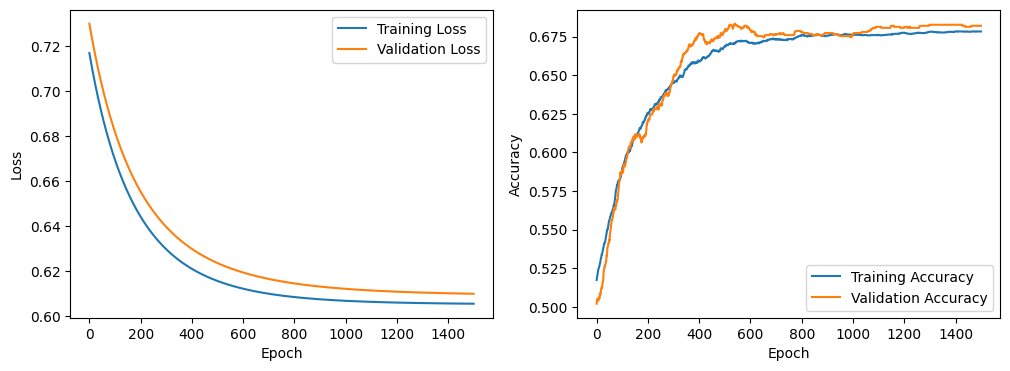

In [22]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Define logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train_tensor.shape[1]
model = LogisticRegression(input_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay = 1e-4)

# Training loop
num_epochs = 1500
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Forward pass
    outputs_tensor = model(X_train_tensor)
    loss_tensor = criterion(outputs_tensor, y_train_tensor.view(-1, 1))

    # Calculate accuracy
    predictions_tensor = (outputs_tensor >= 0.5).float()
    accuracy_tensor = torch.mean((predictions_tensor == y_train_tensor.view(-1, 1)).float())

    # Backward and optimize
    optimizer.zero_grad()
    loss_tensor.backward()
    optimizer.step()

    # Validation loss and accuracy
    with torch.no_grad():
        val_outputs_tensor = model(X_val_tensor)
        val_loss_tensor = criterion(val_outputs_tensor, y_val_tensor.view(-1, 1))
        val_predictions_tensor = (val_outputs_tensor >= 0.5).float()
        val_accuracy_tensor = torch.mean((val_predictions_tensor == y_val_tensor.view(-1, 1)).float())

    # Save losses and accuracies for plotting
    train_losses.append(loss_tensor.item())
    val_losses.append(val_loss_tensor.item())
    train_accuracies.append(accuracy_tensor.item())
    val_accuracies.append(val_accuracy_tensor.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss_tensor.item():.4f}, Training Accuracy: {accuracy_tensor.item():.4f}, Validation Loss: {val_loss_tensor.item():.4f}, Validation Accuracy: {val_accuracy_tensor.item():.4f}')

# Plotting the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 2.2 K-Nearest Neighbors

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create a KNN model with k=3 (you can adjust the value of k)
knn_model = KNeighborsClassifier(n_neighbors=3)

# Train the KNN model
knn_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred_knn = knn_model.predict(X_train)
accuracy_train_knn = accuracy_score(y_train, y_train_pred_knn)
print("KNN Training Accuracy:", accuracy_train_knn)

# Make predictions on the validation set
y_val_pred_knn = knn_model.predict(X_val)
accuracy_val_knn = accuracy_score(y_val, y_val_pred_knn)
print("KNN Validation Accuracy:", accuracy_val_knn)

KNN Training Accuracy: 0.7943440428380187
KNN Validation Accuracy: 0.5937081659973227


## 2.3 Random Forests

Random Forest Training Accuracy: 0.7024765729585006
Random Forest Validation Accuracy: 0.678045515394913


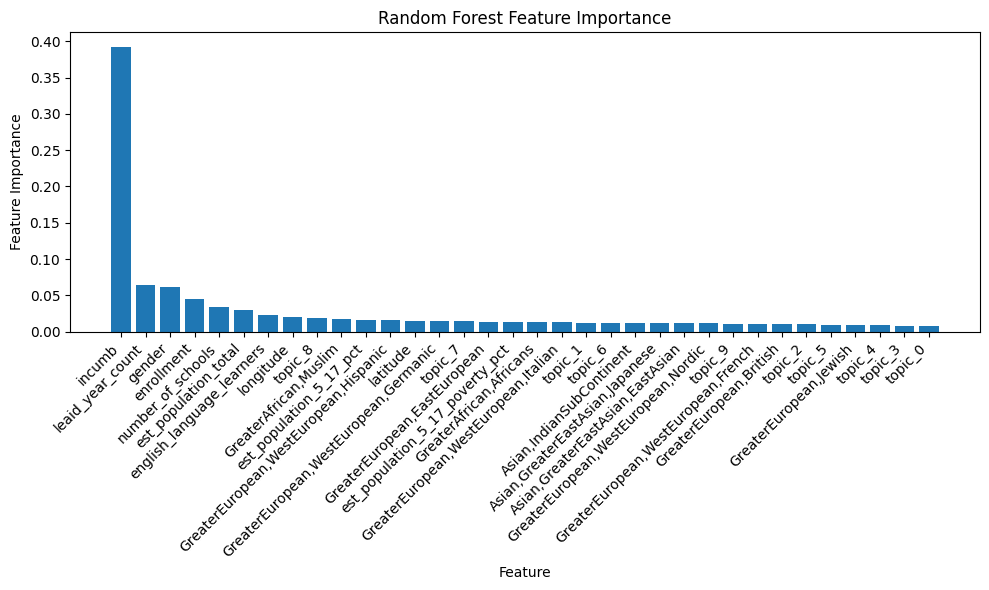

In [24]:
# Train Random Forest
random_forest_model = RandomForestClassifier(random_state=41, max_depth=5)
random_forest_model.fit(X_train, y_train)

y_train_pred_rf = random_forest_model.predict(X_train)
accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
print("Random Forest Training Accuracy:", accuracy_rf)

y_val_pred_rf = random_forest_model.predict(X_val)
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
print("Random Forest Validation Accuracy:", accuracy_rf)

feature_importances = random_forest_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

## 2.4 Gradient Boosting Classifier

GBM Validation Accuracy: 0.6894243641231593


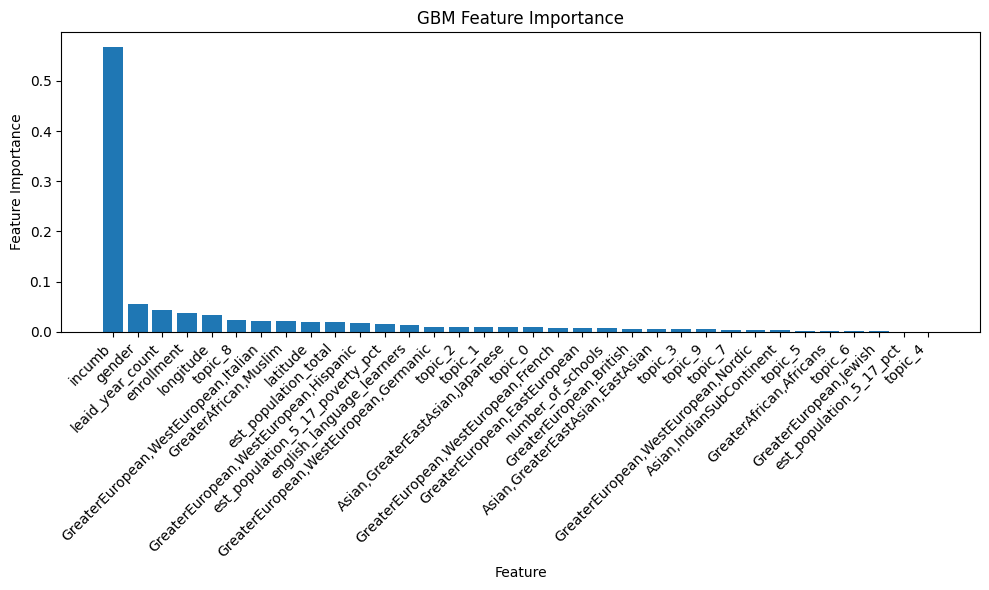

In [25]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score
import numpy as np

# Assuming you have your data (X_train, y_train) and feature_names defined

# Create a Gradient Boosting Classifier
gbm_model = GradientBoostingClassifier(random_state=42, n_estimators=15, learning_rate=0.3, max_depth=3)

# Perform 5-fold cross-validation
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metric (accuracy in this case)
#scorer = make_scorer(accuracy_score)

# Perform cross-validation and print the results
##cross_val_results = cross_val_score(gbm_model, X_train, y_train, cv=cv, scoring=scorer)
#print("Cross-Validation Results (Accuracy):", cross_val_results)
#print("Mean Accuracy:", np.mean(cross_val_results))

# Train the GBM model on the entire training set
gbm_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred_gbm = gbm_model.predict(X_val)
accuracy_val_gbm = accuracy_score(y_val, y_val_pred_gbm)
print("GBM Validation Accuracy:", accuracy_val_gbm)

# Feature importance plotting (similar to your original code)
feature_importances = gbm_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("GBM Feature Importance")
plt.tight_layout()
plt.show()

## 2.5 XGBoost

XGBoost Training Accuracy: 0.6890896921017403
XGBoost Validation Accuracy: 0.6914323962516734


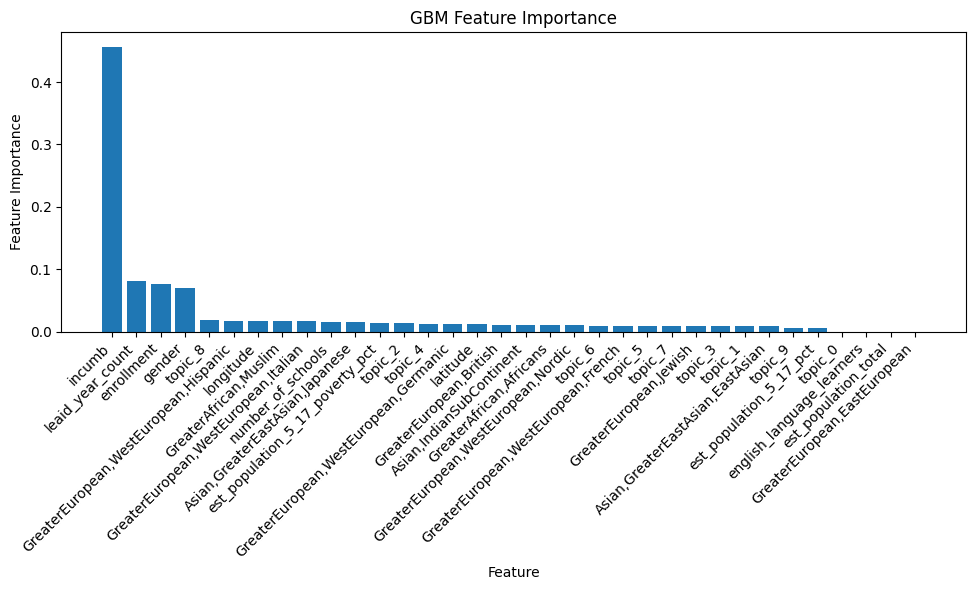

In [26]:
xgboost_model = XGBClassifier(random_state=42, max_depth=1)
xgboost_model.fit(X_train, y_train)

y_train_pred_xgb = xgboost_model.predict(X_train)
accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
print("XGBoost Training Accuracy:", accuracy_xgb)

y_val_pred_xgb = xgboost_model.predict(X_val)
accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
print("XGBoost Validation Accuracy:", accuracy_xgb)


feature_importances = xgboost_model.feature_importances_

# Get the names of t he features

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("GBM Feature Importance")
plt.tight_layout()
plt.show()

## 2.6 SVMs

In [27]:
# Train Support Vector Machine (SVM)
# svm_model = SVC(kernel='rbf', gamma=0.02,random_state=42)
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

y_train_pred_svm = svm_model.predict(X_train)
accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
print("SVM Training Accuracy:", accuracy_svm)

y_val_pred_svm = svm_model.predict(X_val)
accuracy_svm = accuracy_score(y_val, y_val_pred_svm)
print("SVM Validation Accuracy:", accuracy_svm)

SVM Training Accuracy: 0.7342704149933066
SVM Validation Accuracy: 0.677376171352075


In [28]:
!pip install torch

## 2.7 Fully Connected Neural Network

LOG: Fold [1/5], Epoch [10/150], Training Loss: 0.6351, Training Accuracy: 0.6553, Validation Loss: 0.6228, Validation Accuracy: 0.6673
LOG: Fold [1/5], Epoch [20/150], Training Loss: 0.6160, Training Accuracy: 0.6759, Validation Loss: 0.6105, Validation Accuracy: 0.6794
LOG: Fold [1/5], Epoch [30/150], Training Loss: 0.6113, Training Accuracy: 0.6872, Validation Loss: 0.6076, Validation Accuracy: 0.6888
LOG: Fold [1/5], Epoch [40/150], Training Loss: 0.5994, Training Accuracy: 0.6928, Validation Loss: 0.6130, Validation Accuracy: 0.6841
LOG: Fold [1/5], Epoch [50/150], Training Loss: 0.6011, Training Accuracy: 0.6943, Validation Loss: 0.5991, Validation Accuracy: 0.6881
LOG: Fold [1/5], Epoch [60/150], Training Loss: 0.5980, Training Accuracy: 0.6961, Validation Loss: 0.6094, Validation Accuracy: 0.6774
LOG: Fold [1/5], Epoch [70/150], Training Loss: 0.5911, Training Accuracy: 0.6993, Validation Loss: 0.6153, Validation Accuracy: 0.6767
LOG: Fold [1/5], Epoch [80/150], Training Loss: 

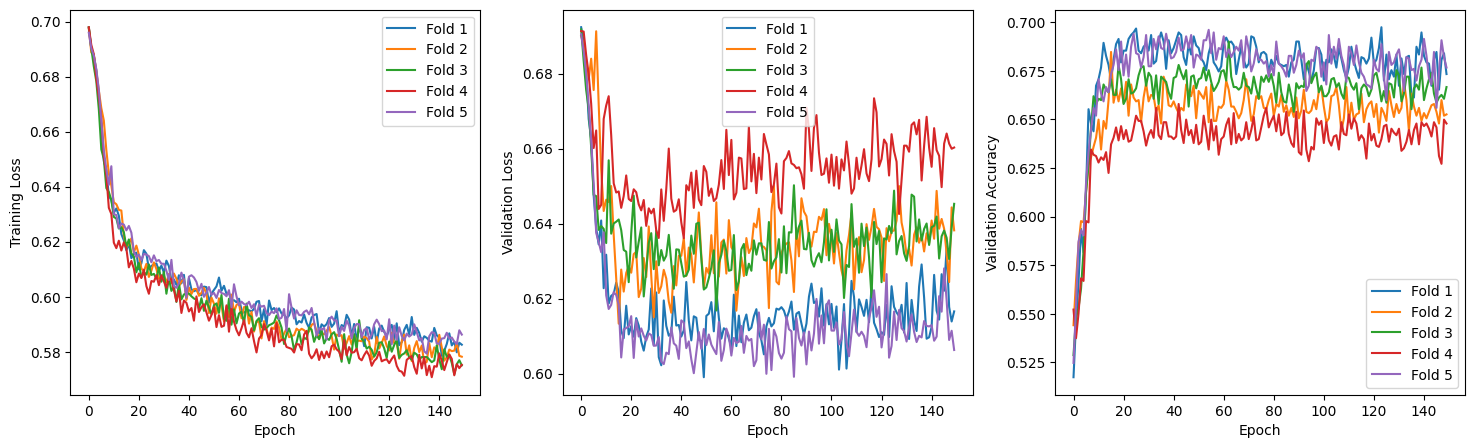

In [40]:
# Define a simple neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Adjust dropout rate as needed
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

class LargerNeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(LargerNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.6)

        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.6)

        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.6)

        self.fc4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.sigmoid(x)
        return x


from sklearn.model_selection import StratifiedKFold

# Combine train and validation sets for cross-validation split
X_combined = torch.cat([X_train_tensor, X_val_tensor], dim=0)
y_combined = torch.cat([y_train_tensor, y_val_tensor], dim=0)

# Set the number of folds for cross-validation
num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store results from each fold
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_test_accuracies = []

best_val_accuracies = []
best_train_accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(X_combined, y_combined)):
    # Split data into training and validation sets
    X_train_fold, X_val_fold = X_combined[train_index], X_combined[val_index]
    y_train_fold, y_val_fold = y_combined[train_index], y_combined[val_index]

    # Initialize the model, loss function, and optimizer
    input_size = X_train_fold.shape[1]
    model = LargerNeuralNetwork(input_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-3)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

    # Training loop
    num_epochs = 150
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    max_val_accuracy = 0
    max_train_accuracy = 0

    for epoch in range(num_epochs):

        # Forward pass
        outputs_tensor = model(X_train_fold)
        loss_tensor = criterion(outputs_tensor, y_train_fold.view(-1, 1))

        # Calculate accuracy
        predictions_tensor = (outputs_tensor >= 0.5).float()
        accuracy_tensor = torch.mean((predictions_tensor == y_train_fold.view(-1, 1)).float())

        if max_train_accuracy < accuracy_tensor.item():
            max_train_accuracy = accuracy_tensor.item()


        # Backward and optimize
        optimizer.zero_grad()
        loss_tensor.backward()
        optimizer.step()
        scheduler.step()
        # Validation loss and accuracy
        with torch.no_grad():
            val_outputs_tensor = model(X_val_fold)
            val_loss_tensor = criterion(val_outputs_tensor, y_val_fold.view(-1, 1))
            val_predictions_tensor = (val_outputs_tensor >= 0.5).float()
            val_accuracy_tensor = torch.mean((val_predictions_tensor == y_val_fold.view(-1, 1)).float())
            if max_val_accuracy < val_accuracy_tensor:
                max_val_accuracy = val_accuracy_tensor.item()

                # Save the model weights
                torch.save(model.state_dict(), f'best_model_weights_fold_{fold + 1}.pth')
                #print(f'New Best Validation Accuracy of {max_val_accuracy:.4f} was found for fold {fold + 1}!')

        # Save losses and accuracies for plotting
        train_losses.append(loss_tensor.item())
        val_losses.append(val_loss_tensor.item())
        train_accuracies.append(accuracy_tensor.item())
        val_accuracies.append(val_accuracy_tensor.item())

        if (epoch + 1) % 10 == 0:
            print(f'LOG: Fold [{fold + 1}/{num_folds}], Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss_tensor.item():.4f}, Training Accuracy: {accuracy_tensor.item():.4f}, Validation Loss: {val_loss_tensor.item():.4f}, Validation Accuracy: {val_accuracy_tensor.item():.4f}')

    # Store results from each fold
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

    # Evaluation on the validation set using the best model
    best_model_fold = LargerNeuralNetwork(input_size)
    model_filename = f'best_model_weights_fold_{fold + 1}.pth'

    # Load the model weights
    best_model_fold.load_state_dict(torch.load(model_filename))

    print(f"Fold {fold + 1} Training Accuracy:", max_train_accuracy)
    print(f"Fold {fold + 1} Validation Accuracy:", max_val_accuracy)

    # log the best validation accuracy
    best_val_accuracies.append(max_val_accuracy)
    best_train_accuracies.append(max_train_accuracy)

    '''
    # Evaluation on the test set using the best model
    with torch.no_grad():
        test_outputs_tensor_fold = best_model_fold(X_test_tensor)
        test_predictions_tensor_fold = (test_outputs_tensor_fold >= 0.5).float()
        test_accuracy_tensor_fold = torch.mean((test_predictions_tensor_fold == y_test_tensor.view(-1, 1)).float())
        print(f"Fold {fold + 1} Test Accuracy:", test_accuracy_tensor_fold.item())

    # Store results from each fold
    all_test_accuracies.append(test_accuracy_tensor_fold.item())
    '''
# After all folds, you can compute
'''
avg_test_accuracy = sum(all_test_accuracies) / len(all_test_accuracies)
print("Average Test Accuracy:", avg_test_accuracy)
'''

# Plotting the training and validation loss
plt.figure(figsize=(18, 5))

# Plotting the training loss
plt.subplot(1, 3, 1)
for fold, train_losses_fold in enumerate(all_train_losses):
    plt.plot(train_losses_fold, label=f'Fold {fold + 1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()

# Plotting the validation loss
plt.subplot(1, 3, 2)
for fold, val_losses_fold in enumerate(all_val_losses):
    plt.plot(val_losses_fold, label=f'Fold {fold + 1}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 3, 3)
for fold, val_accuracies_fold in enumerate(all_val_accuracies):
    plt.plot(val_accuracies_fold, label=f'Fold {fold + 1}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.show()



In [30]:
print("Average Training Accuracy accros all folds: ", np.mean(best_train_accuracies))
print("Average Validation Accuracy accros all folds: ", np.mean(best_val_accuracies))

Average Training Accuracy accros all folds:  0.6986947655677795
Average Validation Accuracy accros all folds:  0.686345386505127


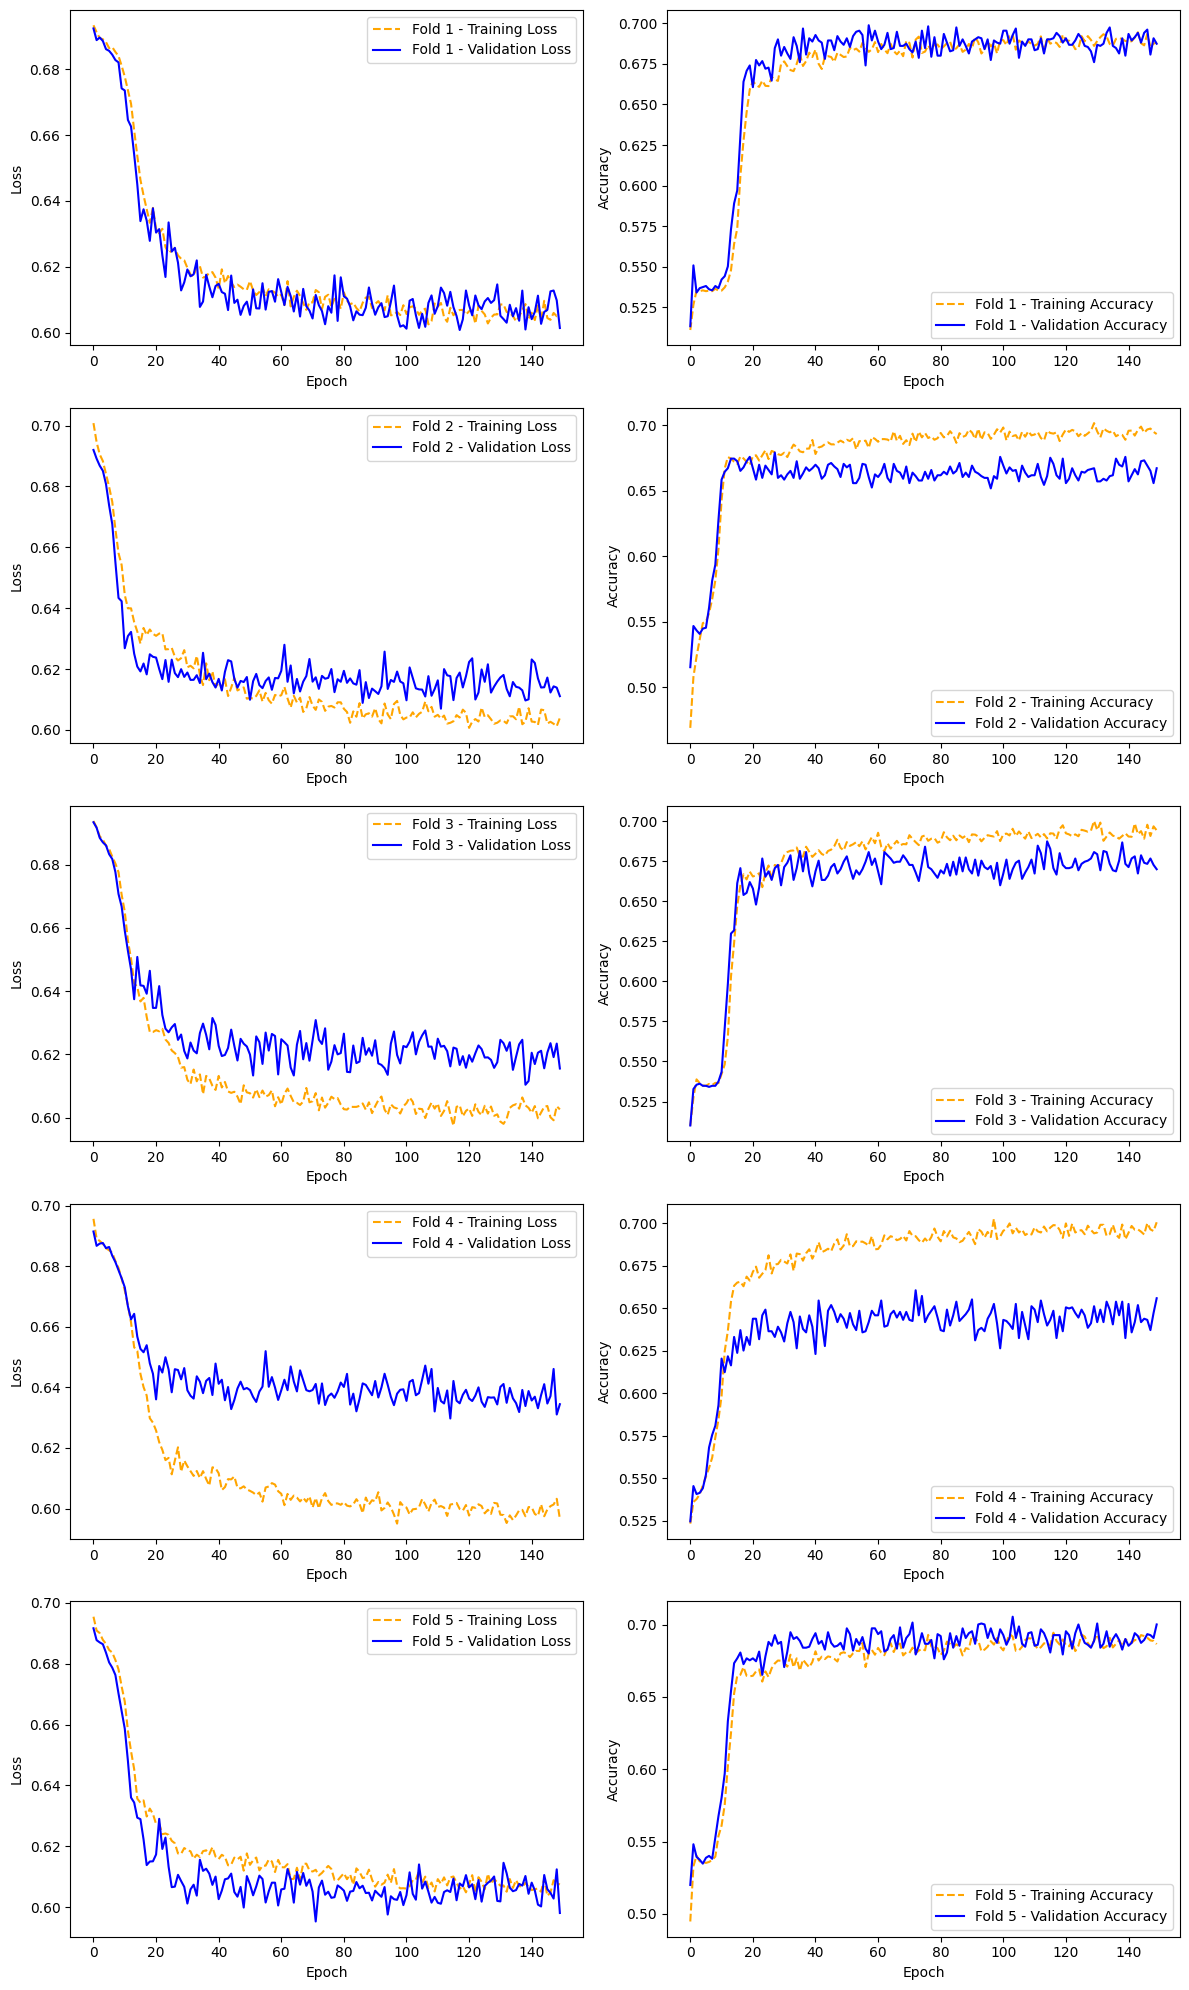

In [31]:
# Assuming all_train_losses, all_val_losses, all_train_accuracies, and all_val_accuracies are lists of lists where each inner list corresponds to a fold.

# Plotting the training and validation loss and accuracy for each fold
num_folds = len(all_train_losses)

plt.figure(figsize=(12, 4 * num_folds))

for fold in range(num_folds):
    # Plotting training loss
    plt.subplot(num_folds, 2, fold * 2 + 1)
    plt.plot(all_train_losses[fold], label=f'Fold {fold + 1} - Training Loss', linestyle='--', color='orange')
    plt.plot(all_val_losses[fold], label=f'Fold {fold + 1} - Validation Loss', linestyle='-', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training accuracy
    plt.subplot(num_folds, 2, fold * 2 + 2)
    plt.plot(all_train_accuracies[fold], label=f'Fold {fold + 1} - Training Accuracy', linestyle='--', color='orange')
    plt.plot(all_val_accuracies[fold], label=f'Fold {fold + 1} - Validation Accuracy', linestyle='-', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

## 2.8 TabNet

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78018 | train_accuracy: 0.54301 | valid_accuracy: 0.5174  |  0:00:00s
epoch 1  | loss: 0.6888  | train_accuracy: 0.54116 | valid_accuracy: 0.52209 |  0:00:00s
epoch 2  | loss: 0.68535 | train_accuracy: 0.57631 | valid_accuracy: 0.5743  |  0:00:00s
epoch 3  | loss: 0.67748 | train_accuracy: 0.56426 | valid_accuracy: 0.55422 |  0:00:01s
epoch 4  | loss: 0.65139 | train_accuracy: 0.62684 | valid_accuracy: 0.64525 |  0:00:01s
epoch 5  | loss: 0.63784 | train_accuracy: 0.64173 | valid_accuracy: 0.64926 |  0:00:01s
epoch 6  | loss: 0.62753 | train_accuracy: 0.65579 | valid_accuracy: 0.66533 |  0:00:02s
epoch 7  | loss: 0.62201 | train_accuracy: 0.65596 | valid_accuracy: 0.67671 |  0:00:02s
epoch 8  | loss: 0.62307 | train_accuracy: 0.66114 | valid_accuracy: 0.67068 |  0:00:03s
epoch 9  | loss: 0.61795 | train_accuracy: 0.66232 | valid_accuracy: 0.68139 |  0:00:03s
epoch 10 | loss: 0.61669 | train_accuracy: 0.66031 | valid_accuracy: 0.67604 |  0:00:04s
epoch 11 | loss: 0.61

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Validation Accuracy: 0.6947791164658634


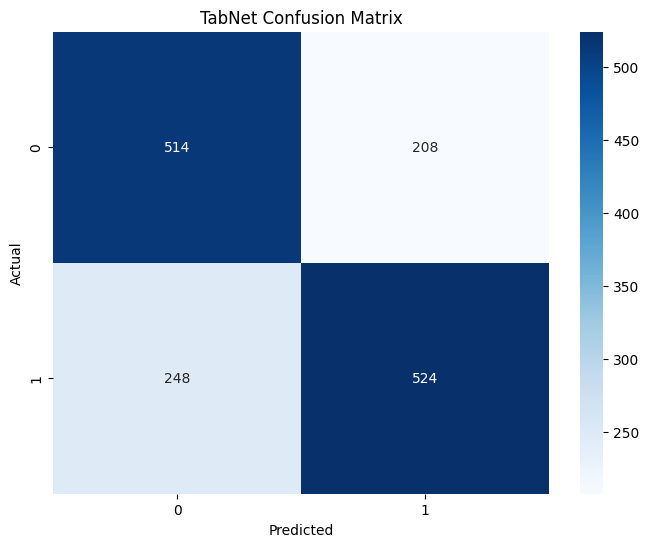

In [41]:
#!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.metrics import accuracy_score
import torch


clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=7e-2),
    scheduler_params={"step_size":10, # how to use learning rate scheduler
                      "gamma":0.6},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax' # This will be overwritten if using pretrain model
)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],


)


# Make predictions on the training set
y_train_pred_tabnet = clf.predict(X_train)
accuracy_train_tabnet = accuracy_score(y_train, y_train_pred_tabnet)
print("TabNet Training Accuracy:", accuracy_train_tabnet)

# Make predictions on the validation set
y_val_pred_tabnet = clf.predict(X_val)
accuracy_val_tabnet = accuracy_score(y_val, y_val_pred_tabnet)
print("TabNet Validation Accuracy:", accuracy_val_tabnet)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the validation set
y_val_pred_tabnet = clf.predict(X_val)

# Create confusion matrix
conf_mat = confusion_matrix(y_val, y_val_pred_tabnet)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('TabNet Confusion Matrix')
plt.show()

In [36]:
from sklearn.metrics import precision_score, recall_score

# Make predictions on the validation set
y_val_pred_tabnet = clf.predict(X_val)

# Compute precision and recall
precision = precision_score(y_val, y_val_pred_tabnet, average='weighted')
recall = recall_score(y_val, y_val_pred_tabnet, average='weighted')

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))


Precision: 0.6959
Recall: 0.6948
